In [1]:
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
# 参数与配置
torch.manual_seed(100)  # 设置随机种子，以使实验结果具有可重复性
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 加载数据集
def dataloader(batch_size, workers=2):
    # 训练集
    train_xdata = load('train_xdata')
    train_ylabel = load('train_ylabel')
    # 验证集
    val_xdata = load('val_xdata')
    val_ylabel = load('val_ylabel')
    # 测试集
    test_xdata = load('test_xdata')
    test_ylabel = load('test_ylabel')

    # 加载数据
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_xdata, train_ylabel),
                                   batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    val_loader = Data.DataLoader(dataset=Data.TensorDataset(val_xdata, val_ylabel),
                                 batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_xdata, test_ylabel),
                                  batch_size=batch_size, shuffle=True, num_workers=workers, drop_last=True)
    return train_loader, val_loader, test_loader

batch_size = 64
# 加载数据
train_loader, val_loader, test_loader = dataloader(batch_size)

print(len(train_loader))
print(len(val_loader))
print(len(test_loader))

111
31
15


定义裁剪模块

In [2]:
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

定义 TCN 卷积+残差 模块

In [3]:
from torch.nn.utils import parametrizations

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.5):
        super(TemporalBlock, self).__init__()
        """
        params: 构成TCN的核心Block, 原作者在图中成为Residual block, 是因为它存在残差连接.
        但注意, 这个模块包含了2个Conv1d.

        n_inputs         : 输入通道数或者特征数
        n_outputs        : 输出通道数或者特征数
        kernel_size      : 卷积核大小
        stride           : 步长, 在TCN固定为1
        dilation         : 膨胀系数. 与这个Residual block(或者说, 隐藏层)所在的层数有关系. 
                            例如, 如果这个Residual block在第1层, dilation = 2**0 = 1;
                                    如果这个Residual block在第2层, dilation = 2**1 = 2;
                                    如果这个Residual block在第3层, dilation = 2**2 = 4;
                                    如果这个Residual block在第4层, dilation = 2**3 = 8 ......
        padding          : 填充系数. 与kernel_size和dilation有关
        dropout          : drop_out比率
        """
        # 第一层 卷积
        self.conv1 = parametrizations.weight_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        # 因为 padding 的时候, 在序列的左边和右边都有填充, 所以要裁剪
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

         # 第二层 卷积
        self.conv2 =parametrizations.weight_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size,
                                           stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.net = nn.Sequential(self.conv1, self.chomp1, self.relu1, self.dropout1,
                                 self.conv2, self.chomp2, self.relu2, self.dropout2)

        # 1×1的卷积. 只有在进入Residual block的通道数与出Residual block的通道数不一样时使用.
        # 一般都会不一样, 除非num_channels这个里面的数, 与num_inputs相等. 例如[5,5,5], 并且num_inputs也是5
        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None  # 进行下采样

        # 在整个Residual block中有非线性的激活
        self.relu = nn.ReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.01)
        self.conv2.weight.data.normal_(0, 0.01)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.01)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        out = out + res
        out = self.relu(out)
        return out

定义 TCN类模型

In [4]:
class TCNModel(nn.Module):
    def __init__(self, input_dim, num_channels, kernel_size, output_dim, dropout= 0.5):
        super(TCNModel, self).__init__()
        """
        params:
        input_dim          : 输入数据的维度
        num_channels       : 每个TemporalBlock中的输出通道数 
                                例如[5,12,3], 代表有3个block, 
                                block1的输出channel数量为5; 
                                block2的输出channel数量为12;
                                block3的输出channel数量为3.
        kernel_size        : 卷积核大小
        output_dim         : 输出维度
        dropout            : drop_out比率
        """
        # TCN 层
        layers = []
        num_levels = len(num_channels)
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_dim if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers += [TemporalBlock(in_channels, out_channels, kernel_size, stride=1, dilation=dilation_size, padding=(kernel_size-1) * dilation_size, dropout=dropout)]
        
        self.network = nn.Sequential(*layers)
       
        # 平局池化
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        # classifier
        self.classifier  = nn.Linear(num_channels[-1] , output_dim) 
    
    def forward(self, input_seq):
        # 数据预处理
        # 把数据进行堆叠 1*1024 ->  32 * 32
        batch_size = input_seq.size(0)
        # 当然， 还可以 堆叠 为其他形状的矩阵
        input_seq = input_seq.view(batch_size, 32, 32) 
        # 送入 TCN 层
        # TCN 输入 （batch_size, channels, length）
        tcn_features = self.network(input_seq)  # torch.Size([64, 128, 32])
        # print(tcn_features.size()) # torch.Size([64, 128, 32])

        # 序列平均池化操作
        x = self.avgpool(tcn_features)  # B C 1  torch.Size([64, 128, 1])
        flat_tensor = x.view(batch_size, -1) # torch.Size([64, 128])
        out = self.classifier(flat_tensor) # torch.Size([32, 10] 

        return out

输入数据的形状是
 1. print(seq.size(), labels.size()) 
 2. torch.Size([64, 1024])    torch.Size([64])

In [5]:
# 定义模型参数
# TCN 参数
input_dim = 32 # 输入维度 把数据进行堆叠 1*1024 ->  32 * 32
num_channels = [32, 64, 128]  # 每个TemporalBlock中的输出通道数
kernel_size = 3  # 卷积核大小
output_dim = 5  # 输出的特征维度 5分类

model = TCNModel(input_dim, num_channels, kernel_size, output_dim) 
# 定义损失函数和优化函数 
loss_function = nn.CrossEntropyLoss(reduction='sum')  # loss
learn_rate = 0.0003
optimizer = torch.optim.Adam(model.parameters(), learn_rate)  # 优化器

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

    32
    32
  3072
    32
    32
  3072
    64
    64
  6144
    64
    64
 12288
  2048
    64
   128
   128
 24576
   128
   128
 49152
  8192
   128
   640
     5
______
110277


In [6]:
print(model)

TCNModel(
  (network): Sequential(
    (0): TemporalBlock(
      (conv1): ParametrizedConv1d(
        32, 32, kernel_size=(3,), stride=(1,), padding=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.5, inplace=False)
      (conv2): ParametrizedConv1d(
        32, 32, kernel_size=(3,), stride=(1,), padding=(2,)
        (parametrizations): ModuleDict(
          (weight): ParametrizationList(
            (0): _WeightNorm()
          )
        )
      )
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.5, inplace=False)
      (net): Sequential(
        (0): ParametrizedConv1d(
          32, 32, kernel_size=(3,), stride=(1,), padding=(2,)
          (parametrizations): ModuleDict(
            (weight): ParametrizationList(
              (0): _WeightNorm()
            )
          )
        )
 

Epoch:  1 train_Loss: 1.61048390 train_Accuracy:0.1889
Epoch:  1 val_Loss:1.61017515,  validate_Acc:0.1920
Epoch:  2 train_Loss: 1.60988212 train_Accuracy:0.1948
Epoch:  2 val_Loss:1.60977961,  validate_Acc:0.1900
Epoch:  3 train_Loss: 1.60981176 train_Accuracy:0.2059
Epoch:  3 val_Loss:1.60940320,  validate_Acc:0.1895
Epoch:  4 train_Loss: 1.60033175 train_Accuracy:0.2472
Epoch:  4 val_Loss:1.53103410,  validate_Acc:0.3846
Epoch:  5 train_Loss: 1.17966941 train_Accuracy:0.4817
Epoch:  5 val_Loss:0.98825887,  validate_Acc:0.5312
Epoch:  6 train_Loss: 0.89671268 train_Accuracy:0.5826
Epoch:  6 val_Loss:1.01235196,  validate_Acc:0.4733
Epoch:  7 train_Loss: 0.82311576 train_Accuracy:0.6091
Epoch:  7 val_Loss:0.81396389,  validate_Acc:0.6522
Epoch:  8 train_Loss: 0.78208900 train_Accuracy:0.6364
Epoch:  8 val_Loss:0.80000675,  validate_Acc:0.6482
Epoch:  9 train_Loss: 0.74679875 train_Accuracy:0.6496
Epoch:  9 val_Loss:0.76303213,  validate_Acc:0.6673
Epoch: 10 train_Loss: 0.73192789 trai

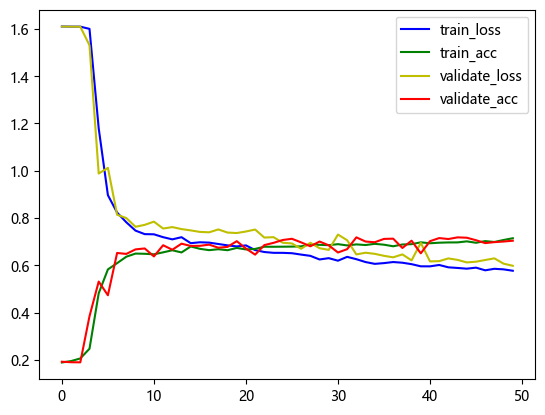

best_accuracy : 0.7182459677419355


In [7]:
# 训练模型
import time
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc("font", family='Microsoft YaHei')

def model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader):
    model = model.to(device)
    # 样本长度
    train_size = len(train_loader) * batch_size
    val_size = len(val_loader) * batch_size

    # 最高准确率  最佳模型
    best_accuracy = 0.0
    best_model = model

    train_loss = []     # 记录在训练集上每个epoch的loss的变化情况
    train_acc = []    # 记录在训练集上每个epoch的准确率的变化情况
    validate_acc = []
    validate_loss = []

    # 计算模型运行时间
    start_time = time.time()
    for epoch in range(epochs):
        # 训练
        model.train()

        loss_epoch = 0.    #保存当前epoch的loss和
        correct_epoch = 0  #保存当前epoch的正确个数和
        for seq, labels in train_loader: 
            seq, labels = seq.to(device), labels.to(device)
            # print(seq.size(), labels.size()) torch.Size([32, 7, 1024]) torch.Size([32])
            # 每次更新参数前都梯度归零和初始化
            optimizer.zero_grad()
            # 前向传播
            y_pred = model(seq)  #   torch.Size([16, 10])
            # 对模型输出进行softmax操作，得到概率分布
            probabilities = F.softmax(y_pred, dim=1)
            # 得到预测的类别
            predicted_labels = torch.argmax(probabilities, dim=1)
            # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
            correct_epoch += (predicted_labels == labels).sum().item()
            # 损失计算
            loss = loss_function(y_pred, labels)
            loss_epoch += loss.item()
            # 反向传播和参数更新
            loss.backward()
            optimizer.step()
        #     break
        # break
        # 计算准确率
        train_Accuracy  = correct_epoch/train_size 
        train_loss.append(loss_epoch/train_size)
        train_acc.append(train_Accuracy)
        print(f'Epoch: {epoch+1:2} train_Loss: {loss_epoch/train_size:10.8f} train_Accuracy:{train_Accuracy:4.4f}')
        # 每一个epoch结束后，在验证集上验证实验结果。
        with torch.no_grad():
            # 将模型设置为评估模式
            model.eval()
            loss_validate = 0.
            correct_validate = 0
            for data, label in val_loader:
                data, label = data.to(device), label.to(device)
                pre = model(data)
                # 对模型输出进行softmax操作，得到概率分布
                probabilities = F.softmax(pre, dim=1)
                # 得到预测的类别
                predicted_labels = torch.argmax(probabilities, dim=1)
                # 与真实标签进行比较，计算预测正确的样本数量  # 计算当前batch预测正确个数
                correct_validate += (predicted_labels == label).sum().item()
                loss = loss_function(pre, label)
                loss_validate += loss.item()
            # print(f'validate_sum:{loss_validate},  validate_Acc:{correct_validate}')
            val_accuracy = correct_validate/val_size 
            print(f'Epoch: {epoch+1:2} val_Loss:{loss_validate/val_size:10.8f},  validate_Acc:{val_accuracy:4.4f}')
            validate_loss.append(loss_validate/val_size)
            validate_acc.append(val_accuracy)
            # 如果当前模型的准确率优于之前的最佳准确率，则更新最佳模型
            #保存当前最优模型参数
            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_model = model# 更新最佳模型的参数

    # 保存最后的参数
    # torch.save(model.state_dict(), 'final_model_tcn.pt')
    # 保存最好的参数
    torch.save(best_model.state_dict(), 'best_model_tcn.pt')
   
    print(f'\nDuration: {time.time() - start_time:.0f} seconds')
    plt.plot(range(epochs), train_loss, color = 'b',label = 'train_loss')
    plt.plot(range(epochs), train_acc, color = 'g',label = 'train_acc')
    plt.plot(range(epochs), validate_loss, color = 'y',label = 'validate_loss')
    plt.plot(range(epochs), validate_acc, color = 'r',label = 'validate_acc')
    plt.legend()
    plt.show()   #显示 lable 
    print("best_accuracy :", best_accuracy)

batch_size = 64
epochs = 50
# 模型训练
model_train(batch_size, epochs, model, optimizer, loss_function, train_loader, val_loader)

In [8]:
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
# 模型 测试集 验证  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 有GPU先用GPU训练

# 得出每一类的分类准确率
# 加载模型的状态字典
model.load_state_dict(torch.load('best_model_tcn.pt'))
model = model.to(device)

# 使用测试集数据进行推断并计算每一类的分类准确率
class_labels = []  # 存储类别标签
predicted_labels = []  # 存储预测的标签

with torch.no_grad():
    for test_data, test_label in test_loader:
        # 将模型设置为评估模式
        model.eval()
        test_data = test_data.to(device)
        test_output = model(test_data)
        probabilities = F.softmax(test_output, dim=1)
        predicted = torch.argmax(probabilities, dim=1)
        
        class_labels.extend(test_label.tolist())
        predicted_labels.extend(predicted.tolist())

# 混淆矩阵
confusion_mat = confusion_matrix(class_labels, predicted_labels)

from sklearn.metrics import classification_report
# 计算每一类的分类准确率
report = classification_report(class_labels, predicted_labels, digits=4)
print(report)

              precision    recall  f1-score   support

           0     0.9948    0.9600    0.9771       200
           1     0.6482    0.6754    0.6615       191
           2     0.6818    0.1596    0.2586       188
           3     0.5179    0.8457    0.6424       188
           4     0.6959    0.7824    0.7366       193

    accuracy                         0.6885       960
   macro avg     0.7077    0.6846    0.6553       960
weighted avg     0.7111    0.6885    0.6597       960



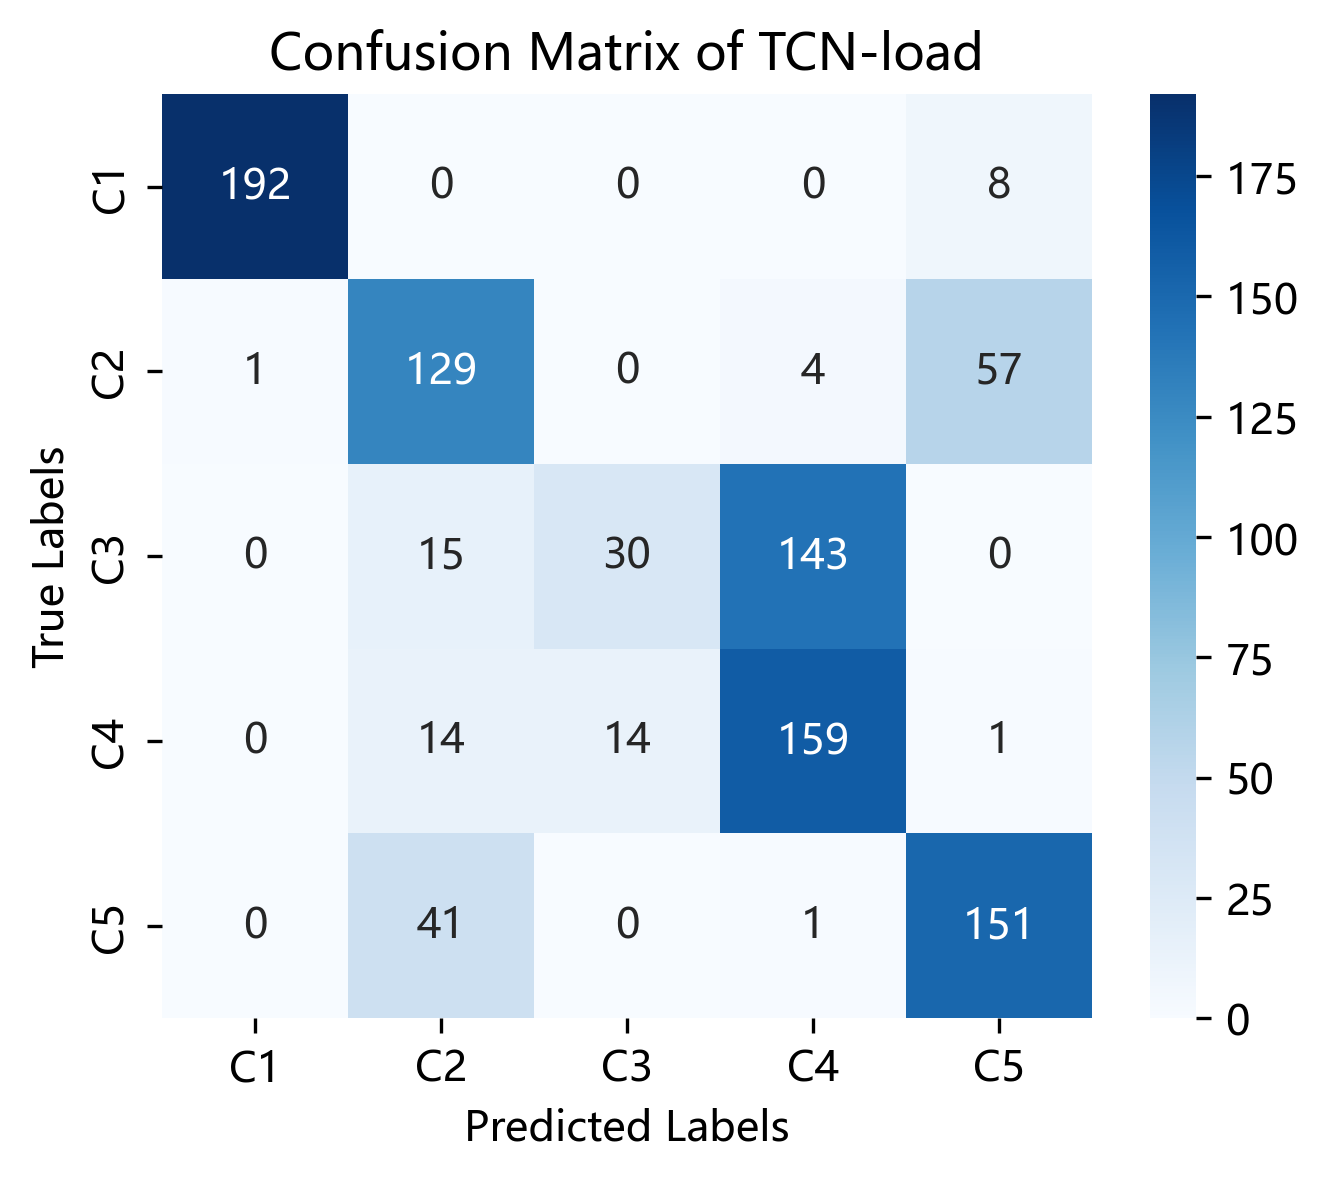

In [9]:
# 绘制混淆矩阵
import matplotlib.pyplot as plt
import seaborn as sns
# 原始标签和自定义标签的映射
label_mapping = {
    0: "C1",1: "C2",2: "C3",3: "C4",4: "C5",
    #5: "C6",6: "C7",7: "C8",8: "C9",9: "C10",
}

# 绘制混淆矩阵
plt.figure(figsize=(5, 4), dpi=300)
sns.heatmap(confusion_mat,  xticklabels=label_mapping.values(), yticklabels=label_mapping.values(),annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix of TCN-load')
plt.savefig("tcn_confusion.png")
plt.show()

In [21]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 模型分数
original_data = np.array(original_data)  
pre_data = np.array(pre_data)  
score = r2_score(original_data, pre_data)
print('*'*50)
print('TCN 模型分数--R^2:', 0.9512684896252379)

print('*'*50)
# 测试集上的预测误差
test_mse = mean_squared_error(original_data, pre_data)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(original_data, pre_data)
print('测试数据集上的均方误差--MSE: ',test_mse)
print('测试数据集上的均方根误差--RMSE: ',test_rmse)
print('测试数据集上的平均绝对误差--MAE: ',test_mae)


NameError: name 'original_data' is not defined